In [37]:
# Pandas
import pandas as pd
import os 

from config import PASSWORD
import matplotlib.pyplot as plt
from sqlalchemy import inspect, create_engine
database_path = "../Resources/wk9_employees.sql"

In [38]:
# Create Engine
host = "localhost"
port = 5432
db = "sql_wk9_hw"
user = "postgres"


path = f'postgresql://{user}:{PASSWORD}@{host}:{port}/{db}'
engine = create_engine(path)

In [39]:
inspector = inspect(engine)

In [40]:
for table in inspector.get_table_names():
    columns = inspector.get_columns(table)
    print(table)
    print()
    for column in columns:
        print(column['name'])
    
    display(pd.DataFrame(columns))
    
    print()

employees

id
emp_no
emp_title_id
birth_date
first_name
last_name
sex
hire_date
last_update


,name,type,nullable,default,autoincrement,comment
0,id,INTEGER,False,nextval('employees_id_seq'::regclass),True,None
1,emp_no,INTEGER,False,None,False,None
2,emp_title_id,VARCHAR(30),False,None,False,None
3,birth_date,VARCHAR(20),True,None,False,None
4,first_name,VARCHAR(20),False,None,False,None
5,last_name,VARCHAR(20),False,None,False,None
6,sex,VARCHAR(10),False,None,False,None
7,hire_date,VARCHAR(20),False,None,False,None
8,last_update,TIMESTAMP,False,LOCALTIMESTAMP,False,None



dept_emp

id
emp_no
dept_no
last_update


,name,type,nullable,default,autoincrement,comment
0,id,INTEGER,False,nextval('dept_emp_id_seq'::regclass),True,None
1,emp_no,INTEGER,False,None,False,None
2,dept_no,VARCHAR(30),False,None,False,None
3,last_update,TIMESTAMP,False,LOCALTIMESTAMP,False,None



departments

id
dept_no
dept_name
last_update


,name,type,nullable,default,autoincrement,comment
0,id,INTEGER,False,nextval('departments_id_seq'::regclass),True,None
1,dept_no,VARCHAR(10),False,None,False,None
2,dept_name,VARCHAR(30),True,None,False,None
3,last_update,TIMESTAMP,False,LOCALTIMESTAMP,False,None



dept_manager

id
dept_no
emp_no
last_update


,name,type,nullable,default,autoincrement,comment
0,id,INTEGER,False,nextval('dept_manager_id_seq'::regclass),True,None
1,dept_no,VARCHAR(30),False,None,False,None
2,emp_no,INTEGER,False,None,False,None
3,last_update,TIMESTAMP,False,LOCALTIMESTAMP,False,None



title

id
title_id
title
last_update


,name,type,nullable,default,autoincrement,comment
0,id,INTEGER,False,nextval('title_id_seq'::regclass),True,None
1,title_id,VARCHAR(20),False,None,False,None
2,title,VARCHAR(30),True,None,False,None
3,last_update,TIMESTAMP,False,LOCALTIMESTAMP,False,None



salaries

id
emp_no
salary
last_update


,name,type,nullable,default,autoincrement,comment
0,id,INTEGER,False,nextval('salaries_id_seq'::regclass),True,None
1,emp_no,INTEGER,False,None,False,None
2,salary,INTEGER,False,None,False,None
3,last_update,TIMESTAMP,False,LOCALTIMESTAMP,False,None


In [70]:
#https://stackoverflow.com/questions/19103991/create-range-bins-from-sql-server-table-for-histograms

query = """
        With table1 as (
            SELECT 
                CASE 
                    WHEN salary = 40000 then '40K'
                    WHEN salary > 40000 and salary < 50000 then '40-50K'
                    WHEN salary >= 50000 and salary < 60000 then '50-60K'
                    WHEN salary >= 60000 and salary < 70000 then '60-70K'
                    WHEN salary >= 70000 and salary < 80000 then '70-80K'
                    Else '80K+'
                End as salary_bin
            From 
                salaries 
            )

            SELECT
                salary_bin,
                Count(salary_bin)
            FROM
                table1
            GROUP BY
                salary_bin;

       
        """

conn = engine.connect()

In [71]:
# Query All Records in the the Database
df = pd.read_sql(query, conn)
df

,salary_bin,count
0,70-80K,24814
1,40K,95346
2,80K+,17417
3,40-50K,63119
4,60-70K,41413
5,50-60K,57915


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   salary_bin  6 non-null      object
 1   count       6 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 224.0+ bytes


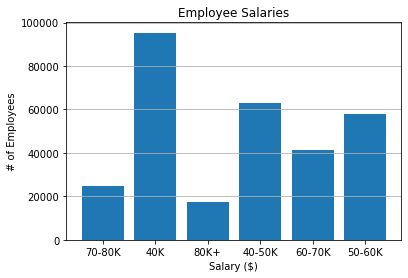

In [73]:
plt.bar(df.salary_bin, df['count'])
plt.xlabel("Salary ($)")
plt.ylabel("# of Employees")
plt.title("Employee Salaries")
#plt.xticks(rotation=90)
plt.grid(axis='y')

plt.show()

In [76]:
query1 = """
        Select 
            salary
        From
            salaries;
        """

In [77]:
df1 = pd.read_sql(query1, conn)
df1.head()

,salary
0,60117
1,65828
2,40006
3,40054
4,78228


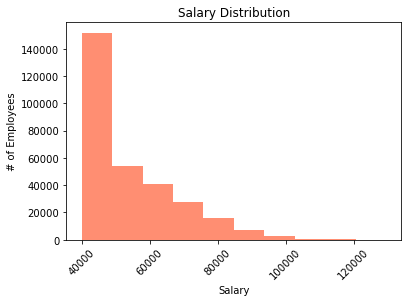

In [96]:
plt.hist(df1.salary, bins=10, color='#FF8E72')
plt.xlabel('Salary')
plt.ylabel('# of Employees')
plt.title("Salary Distribution")
plt.xticks(rotation=45)

plt.savefig('salary_hist.png', bbox_inches='tight')
plt.show()


In [49]:
query2 = """
        Select 
            t.title, avg(s.salary) as avg_salary
        From
            salaries as s
            join employees as e on e.emp_no=s.emp_no
            join title as t on e.emp_title_id=t.title_id
        group by 
            t.title
        order by 
            avg_salary desc;
        """

df2 = pd.read_sql(query2, conn)
df2

,title,avg_salary
0,Senior Staff,58550.172704
1,Staff,58465.382850
2,Manager,51531.041667
3,Technique Leader,48582.896092
4,Assistant Engineer,48564.434447
5,Engineer,48535.336511
6,Senior Engineer,48506.799871


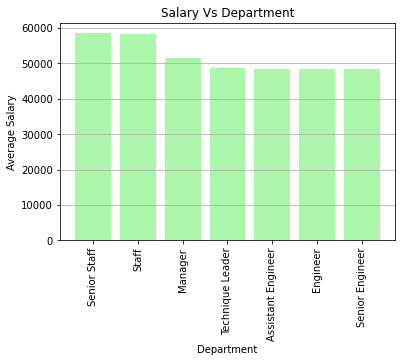

In [97]:
plt.bar(df2.title, df2.avg_salary, color='#ACF6AC')
plt.xlabel("Department")
plt.ylabel("Average Salary")
plt.title("Salary Vs Department")
plt.xticks(rotation=90)
plt.grid(axis='y')

plt.savefig('salary_bar.png', bbox_inches='tight')        
plt.show()